In [2]:
#!pip install --upgrade diffusers accelerate transformers


## Diffusers and Pretrained Models


Diffusers are a type of generative model used to create images from textual descriptions. They work by iteratively refining a noisy image until it matches the given text prompt. This process is guided by a neural network trained on a large dataset of images and their corresponding descriptions.

In this notebook, we are using the `StableDiffusionPipeline` from the Hugging Face `diffusers` library. This pipeline allows us to generate images based on text prompts using a pretrained model. The model we are using is `runwayml/stable-diffusion-v1-5`, which has been trained on a diverse set of images and text descriptions.

The pretrained model is loaded from Hugging Face's model hub, which provides a wide range of models for various tasks. By using a pretrained model, we can leverage the knowledge it has gained from extensive training, allowing us to generate high-quality images without needing to train a model from scratch.
To under stable the inner working of stable diffusion checkout this [blog](https://rekil156.github.io/rekilblog/posts/lesson9_stableDissufion/Lesson9.html).

<div style="text-align: center;">
<h3> Stable Diffusion during inference </h3>
    <a href="https://huggingface.co/blog/stable_diffusion" target="_blank">
        <img src="Resource_image/Stable_diffusion_inference.png" alt="image" style="max-width:100%;">
    </a>
</div>


In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from diffusers import StableDiffusionPipeline
from PIL import Image
from fastcore.all import concat

c:\Users\badar\anaconda3\envs\CV_Zero2Hero\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def create_image_grid(images, rows, cols):
    """
    Create a grid of images from a list of images.
    
    Parameters:
    images (list): List of images (PIL Image objects).
    rows (int): Number of rows in the grid.
    cols (int): Number of columns in the grid.
    
    Returns:
    Image: A single image containing all the input images arranged in a grid.
    """
    # Get the size of the first image
    w, h = images[0].size
    
    # Create a new blank image with the size to fit the grid
    grid = Image.new('RGB', (w * cols, h * rows))
    
    # Paste each image into the grid
    for i, img in enumerate(images):
        grid.paste(img, box=(i % cols * w, i // cols * h))
    
    return grid

In [3]:
?StableDiffusionPipeline.from_pretrained

Signature:
StableDiffusionPipeline.from_pretrained(
    pretrained_model_name_or_path: Union[str, os.PathLike, NoneType],
    **kwargs,
)
Docstring:
Instantiate a PyTorch diffusion pipeline from pretrained pipeline weights.

The pipeline is set in evaluation mode (`model.eval()`) by default.

If you get the error message below, you need to finetune the weights for your downstream task:

```
Some weights of UNet2DConditionModel were not initialized from the model checkpoint at runwayml/stable-diffusion-v1-5 and are newly initialized because the shapes did not match:
- conv_in.weight: found shape torch.Size([320, 4, 3, 3]) in the checkpoint and torch.Size([320, 9, 3, 3]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
```

Parameters:
    pretrained_model_name_or_path (`str` or `os.PathLike`, *optional*):
        Can be either:

            - A string, the *repo id* (for example `CompVis/ldm-text2im-

Loading the pretrained model, using the dtype to torch.float16 for mixed precession



In [ ]:
"""
    Tip for limited GPU memory: Load the model with torch.float16 dtype for mixed precision and enable attention slicing.
"""
torch.cuda.empty_cache()
model_path="runwayml/stable-diffusion-v1-5"
cache_dir="model_cache"
device=torch.device("cuda" if torch.cuda.is_available() else "cpu")
try:
    pipe = StableDiffusionPipeline.from_pretrained(model_path, cache_dir=cache_dir,torch_dtype =torch.float16)
    pipe=pipe.to(device)
    print("Model loaded successfully")
except Exception as e:
    print(f"Error loading the model :{e}")
    
pipe.enable_attention_slicing()  #        attention slicing for limited GPU memory

Loading pipeline components...:  43%|████▎     | 3/7 [00:17<00:20,  5.21s/it]

In [7]:
#If you want to see the input parameters of the function add ? before the function name  
??pipe

Signature:     
pipe(
    prompt: Union[str, List[str]] = None,
    height: Optional[int] = None,
    width: Optional[int] = None,
    num_inference_steps: int = 50,
    timesteps: List[int] = None,
    sigmas: List[float] = None,
    guidance_scale: float = 7.5,
    negative_prompt: Union[str, List[str], NoneType] = None,
    num_images_per_prompt: Optional[int] = 1,
    eta: float = 0.0,
    generator: Union[torch._C.Generator, List[torch._C.Generator], NoneType] = None,
    latents: Optional[torch.Tensor] = None,
    prompt_embeds: Optional[torch.Tensor] = None,
    negative_prompt_embeds: Optional[torch.Tensor] = None,
    ip_adapter_image: Union[PIL.Image.Image, numpy.ndarray, torch.Tensor, List[PIL.Image.Image], List[numpy.ndarray], List[torch.Tensor], NoneType] = None,
    ip_adapter_image_embeds: Optional[List[torch.Tensor]] = None,
    output_type: Optional[str] = 'pil',
    return_dict: bool = True,
    cross_attention_kwargs: Optional[Dict[str, Any]] = None,
    guidance_res

c:\Users\badar\anaconda3\envs\CV_Zero2Hero\Lib\site-packages\transformers\models\clip\modeling_clip.py:491: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:555.)
  attn_output = torch.nn.functional.scaled_dot_product_attention(
100%|██████████| 50/50 [24:47<00:00, 29.76s/it]


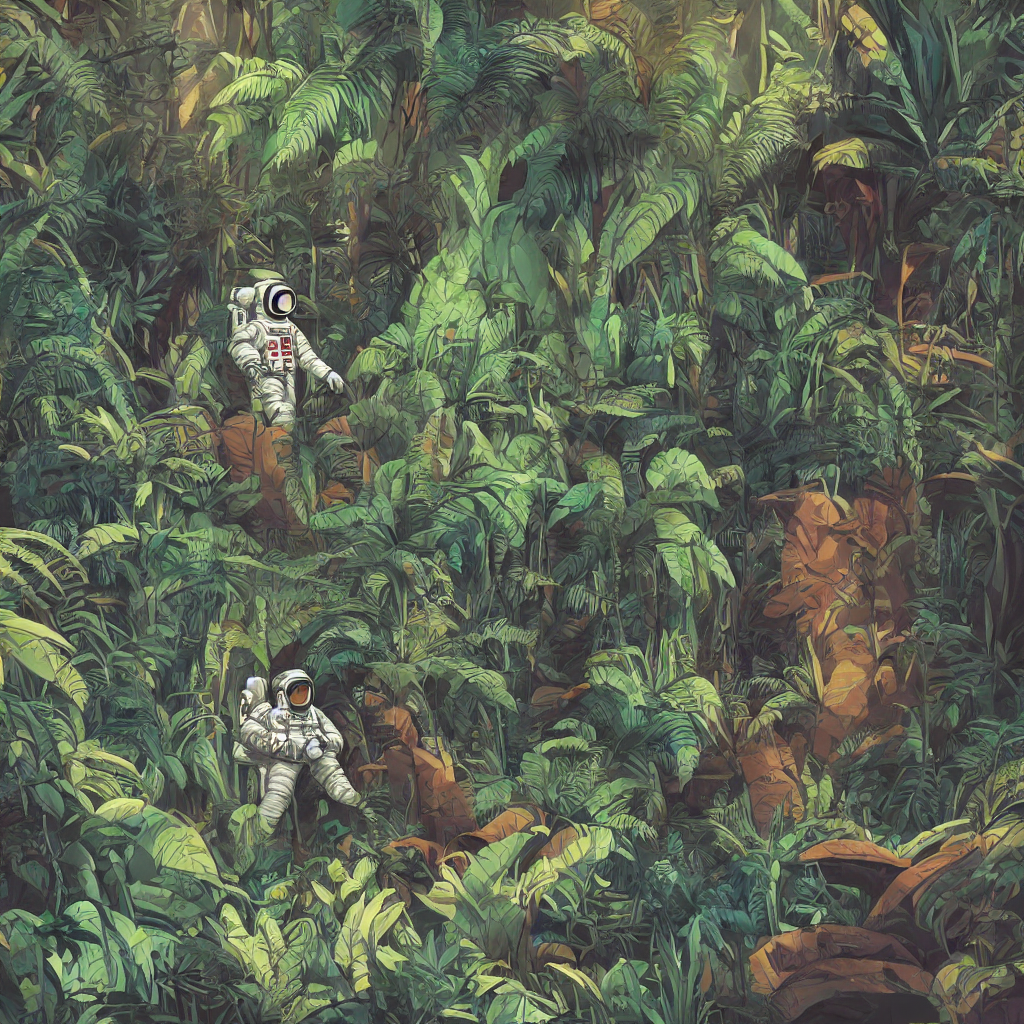

In [6]:
"""
num_inference_steps : int = 50
    How many steps to run the diffusion for before returning the final image.
    Note: Diffusion needs some number of steps to gradually create the image from the noise.
    We see this in coming examples.
"""
torch.manual_seed(42) # For reproducibility
image=pipe(prompt="Astronaut in a jungle, cold color palette, muted colors, detailed, 8k",height=1024,width=1024,num_inference_steps=50)[0]
image[0]

With help of callback we will see how gradually a noise latent is convert to the final image.

In [ ]:
import torch
import matplotlib.pyplot as plt
import os
from diffusers import EulerDiscreteScheduler

# Change the scheduler from default to EulerDiscreteSchedule
pipe.scheduler = EulerDiscreteScheduler.from_config(
    pipe.scheduler.config, use_karras_sigmas=True
)

prompt = "Astronaut in a jungle, cold color palette, muted colors, detailed, 8k"

# num_images_per_prompt=4,

def progress(step, timestep, latents):
    try:
        print(step, timestep, latents[0][0][0][0])

        with torch.no_grad():
            latents = 1 / 0.18215 * latents
            image = pipe.vae.decode(latents).sample

            image = (image / 2 + 0.5).clamp(0, 1)

            # we always cast to float32 as this does not cause significant overhead and is compatible with bfloa16
            image = image.cpu().permute(0, 2, 3, 1).float().numpy()

            # convert to PIL Images
            image = pipe.numpy_to_pil(image)

            plt.figure()
            plt.imshow(image[0])
            plt.show()
    except Exception as e:
        print(f"Error in progress callback: {e}")

try:
    result = pipe(prompt=prompt,
                  num_inference_steps=20,
                  height=512, width=512,
                  guidance_scale=7,
                  callback=progress,
                  callback_steps=5
                  )

    image = result.images[0]

    # Ensure directory exists
    os.makedirs("Generated_Images", exist_ok=True)
    image.save(f"Generated_Images/noise2image.png")
    print(result.nsfw_content_detected)
except Exception as e:
    print(f"Error during inference: {e}")

c:\Users\badar\anaconda3\envs\CV_Zero2Hero\Lib\site-packages\diffusers\pipelines\stable_diffusion\pipeline_stable_diffusion.py:869: FutureWarning: `callback` is deprecated and will be removed in version 1.0.0. Passing `callback` as an input argument to `__call__` is deprecated, consider using `callback_on_step_end`
  deprecate(
c:\Users\badar\anaconda3\envs\CV_Zero2Hero\Lib\site-packages\diffusers\pipelines\stable_diffusion\pipeline_stable_diffusion.py:875: FutureWarning: `callback_steps` is deprecated and will be removed in version 1.0.0. Passing `callback_steps` as an input argument to `__call__` is deprecated, consider using `callback_on_step_end`
  deprecate(
c:\Users\badar\anaconda3\envs\CV_Zero2Hero\Lib\site-packages\transformers\models\clip\modeling_clip.py:491: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:555.)
  attn_output

0 tensor(999., device='cuda:0') tensor(-15.9609, device='cuda:0', dtype=torch.float16)


In [ ]:
class Parrot:

    def fly(self):
        print('Parrot can fly')

    def swim(self):
        print('Parrot can not swim')

class Penguin:

    def fly(self):
        print('Penguin can not fly')

    def swim(self):
        print('Penguin can swim')

# common interface
def flying_test(bird):
    bird.fly()

#instantiate objects
blu = Parrot()
peggy = Penguin()

# passing the object
flying_test(blu)
flying_test(peggy)

In [1]:
import torch
import matplotlib.pyplot as plt

def callback(iter, t, latents):
    try:
        with torch.no_grad():
            latents = 1 / 0.18215 * latents
            image = pipe.vae.decode(latents).sample

            image = (image / 2 + 0.5).clamp(0, 1)

            image = image.cpu().permute(0, 2, 3, 1).float().numpy()

            image = pipe.numpy_to_pil(image)
            plt.figure()
            plt.imshow(image[0])
            plt.show()
    except Exception as e:
        print(f"Error in callback: {e}")

prompt = "Astronaut in a jungle, cold color palette, muted colors, detailed, 8k"

try:
    image = pipe(prompt, callback=callback, callback_steps=5,num_inference_steps=1)
except Exception as e:
    print(f"Error during inference: {e}")

Error during inference: name 'pipe' is not defined


### Playing with Guidance Score

When generating images using a text-to-image model like Stable Diffusion, the **guidance score** (also known as the guidance scale) plays a crucial role in determining how closely the generated image follows the given text prompt. By adjusting the guidance score, you can control the balance between creativity and adherence to the prompt.

#### Lower Guidance Score

With a lower guidance score, the model generates images more freely, without closely following the text prompt. This can result in more creative and diverse images, but they may not accurately reflect the prompt.

#### Higher Guidance Score

With a higher guidance score, the model pays more attention to the text prompt, generating images that closely match the description. This can result in images that are more aligned with the prompt but may be less diverse.

##### The Process

The process works as follows:

1. **Generate Two Images**: The model first generates an image without any prompt, resulting in a kind of random image. Then, the model generates a second image based on the prompt.
2. **Combine Images**: The guidance scale acts like a weighted average, combining these two images to produce the final output. A higher guidance scale gives more weight to the prompt-based image, while a lower guidance scale gives more weight to the random image.

**Example Code to Generate Images with Different Guidance Scores**

Here's an example of how you can generate images with different guidance scores using the Stable Diffusion model:


In [ ]:

prompt="Astronaut in a jungle, cold color palette, muted colors, detailed, 8k"
num_row,num_col=3,3
prompts=[prompt]*num_col
images=concat(pipe(prompts,guidance_scale=g).images for g in [1.1,2.5,9.5])



In [ ]:
"""
Create a grid of images from a list of images results are similar for lower guidance scale low quality and high guidance scale high quality
"""
grid=create_image_grid(images,num_row,num_col)
grid

### Negative Prompte 
This technique used to guide the model away from generating certian deatures or elements in the output image. THis is essentially the opposite of a positive prompt, which specifices what the model
should include in the generated image . 

In [ ]:
torch.manual_seed(23)
prompt="A men wearning green shirt eating pizza"
pipe(prompts).images[0]

In [ ]:
negative_prompt="green shirt"
pipe(prompts,negative_prompts=[negative_prompt]).images[0]

In [39]:
def generate_images(pipe, prompts, batch_size=4,):
    """
    Generate images in batches using Stable Diffusion.
    
    Parameters:
    pipe (StableDiffusionPipeline): Pretrained Stable Diffusion pipeline.
    prompts (list): List of text prompts to generate images.
    batch_size (int): Number of prompts to process in each batch.
    Returns:
    list: List of generated images.
    """
    # Load the pretrained model with mixed precision
   
    
    # Generate images in batches
    images = []
    for i in range(0, len(prompts), batch_size):
        batch_prompts = prompts[i:i+batch_size]
        batch_images = pipe(batch_prompts, num_inference_steps=50).images
        images.extend(batch_images)
    return images

#### Decomposing the elements of the diffusers

In [ ]:
vae=pipe.vae # Variational Autoencoder from diffusion model
text_tokenizer=pipe.tokenizer
text_encoder=pipe.text_encoder
unet=pipe.unet
unet.to("cuda")
text_encoder.to("cuda")
vae.to("cuda")


In [ ]:
'''
    Purpose of the tokenizer function is to split the text into tokens eg. words, subwords, or characters and convert them into token IDs based on the predefined vocabulary.
    also ensures the all the tokens input have the same length by padding or truncating the input text.
    input:str : Text input to tokenize.
    Returns: input_ids (torch.Tensor): Tensor of token IDs for the input text.
    input_mask (torch.Tensor): Tensor of attention mask for the input text.
'''

text_tokenizer,text_encoder

In [59]:
unet=pipe.unet

In [ ]:
schduler=pipe.scheduler #defualt schduler
schduler

In [ ]:
from diffusers import DDIMScheduler

ddim = DDIMScheduler.from_config(pipe.scheduler.config)
ddim


In [ ]:
from diffusers import EulerAncestralDiscreteScheduler

EulerAD= EulerAncestralDiscreteScheduler.from_config(pipe.scheduler.config)
EulerAD


In [ ]:
from diffusers import DPMSolverMultistepScheduler

DPMMS = DPMSolverMultistepScheduler.from_config(pipe.scheduler.config)
DPMMS

In [ ]:
from diffusers  import LMSDiscreteScheduler
LMSDS=LMSDiscreteScheduler.from_config(pipe.scheduler.config)


In [ ]:
generator = torch.Generator(device="cuda").manual_seed(8)
image = pipe(prompt, generator=generator).images[0]
image

In [82]:
# Some setting for the model
prompt="Cute cat with a hat, cartoon style, vibrant colors, detailed, 8k"
height=300
width=300
num_inference_steps=30
guidance_scale=7
generator = torch.Generator(device="cuda").manual_seed(8) # Seed generator to create the initial latent noise
batch_size=1



In [ ]:
# Text preprocessing
text_input=text_tokenizer(prompt,padding="max_length",max_length=text_tokenizer.model_max_length,truncation=True,return_tensors="pt")
text_input

In [ ]:
with torch.no_grad():
    text_embeddings = text_encoder(text_input.input_ids.to("cuda"))[0]
print(f"Shape of he clip embedding :{text_embeddings[0].shape}")
print(f"Shape of the text input :{text_input.input_ids.shape}")

In [ ]:
[""]*batch_size

In [ ]:
max_length=text_input.input_ids.shape[-1]
uncond_input=text_tokenizer([""]*batch_size,padding="max_length",max_length=max_length,truncation=True,return_tensors="pt")
uncond_input.to("cuda")

In [87]:
with torch.no_grad():
    uncond_embeddings = text_encoder(uncond_input.input_ids.to("cuda"))[0]

In [90]:
text_embeddings = torch.cat([uncond_embeddings, text_embeddings])

In [ ]:
text_embeddings.shape,text_embeddings.shape,text_embeddings.shape

In [92]:
def set_timesteps(scheduler,num_inference_steps):
    """ Set the number of inference steps for the scheduler. 
    Args:
        scheduler (_type_): _description_
        num_inference_steps (_type_): _description_
    """
    scheduler.set_timesteps(num_inference_steps)
    scheduler.timesteps=scheduler.timesteps.to(torch.float16)

In [93]:
set_timesteps(LMSDS,num_inference_steps)

In [ ]:
latents = torch.randn(
  (batch_size, unet.in_channels, height // 8, width // 8),
  generator=generator,device="cuda"
)

In [95]:
def display_tensor_as_image(tensor,title="Image"):
    """
    Display a tensor as an image using matplotlib.
    Parameters:
    tensor (torch.Tensor): Input tensor to display as an image.
    title (str): Title of the image.
    
    """
    # Move the tensor to CPU and detach from GPU
    tensor = tensor.cpu().detach()
    
    # Normalize the tensor values to be in the range [0, 1]
    tensor=(tensor-tensor.min())/(tensor.max()-tensor.min())
    
    # Convert the tensor to a Numpy arrary
    np_image = tensor.numpy()
    
    #Transpose array to [H,W,C] for displaying
    np_image=np.transpose(np_image,(1,2,0))
    
    # Display the image using matplotlib
    plt.figure(figsize=(8,8))
    plt.imshow(np_image)
    plt.axis("off")
    plt.title(title)
    plt.show()
    
    

In [ ]:
# Set environment variable to avoid OpenMP runtime conflict
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"
display_tensor_as_image(latents[0],title="Initial Latent Noise")    

In [ ]:
latents=latents.to("cuda")
latents = latents *LMSDS.init_noise_sigma # Scaling (previous versions did latents = latents * self.scheduler.sigmas[0]
display_tensor_as_image(latents[0],"Sigma noise added to latents")

In [98]:
from torch import autocast
from tqdm import tqdm


In [ ]:
with autocast("cuda"):  # will fallback to CPU if no CUDA; no autocast for MPS
    for i, t in tqdm(enumerate(LMSDS.timesteps), total=len(LMSDS.timesteps)):
        # expand the latents if we are doing classifier-free guidance to avoid doing two forward passes.
        latent_model_input = torch.cat([latents] * 2)
        sigma = LMSDS.sigmas[i]
        # Scale the latents (preconditioning):
        # latent_model_input = latent_model_input / ((sigma**2 + 1) ** 0.5) # Diffusers 0.3 and below
        latent_model_input = LMSDS.scale_model_input(latent_model_input, t)

        # predict the noise residual
        with torch.no_grad():
            noise_pred = unet(latent_model_input, t, encoder_hidden_states=text_embeddings).sample

        # perform guidance
        noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
        noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)

        # compute the previous noisy sample x_t -> x_t-1
        # latents = scheduler.step(noise_pred, i, latents)["prev_sample"] # Diffusers 0.3 and below
        latents = LMSDS.step(noise_pred, t, latents).prev_sample



In [ ]:
torch_device = "cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"
torch_device

In [ ]:
def set_timesteps(scheduler, num_inference_steps):
    scheduler.set_timesteps(num_inference_steps)
    scheduler.timesteps = scheduler.timesteps.to(torch.float32) # minor fix to ensure MPS compatibility, fixed in diffusers PR 3925

prompt = ["An astronaut in a jungle, cold color palette, muted colors, detailed, 8k"]
height = 512                        # default height of Stable Diffusion
width = 512                         # default width of Stable Diffusion
num_inference_steps = 30            # Number of denoising steps
guidance_scale = 7.5                # Scale for classifier-free guidance
batch_size = 1

# Prep text
text_input = text_tokenizer(prompt, padding="max_length", max_length=text_tokenizer.model_max_length, truncation=True, return_tensors="pt")
with torch.no_grad():
    text_embeddings = text_encoder(text_input.input_ids.to(torch_device))[0]
max_length = text_input.input_ids.shape[-1]
uncond_input=text_tokenizer([""]*batch_size,padding="max_length",max_length=max_length,truncation=True,return_tensors="pt")

with torch.no_grad():
    uncond_embeddings = text_encoder(uncond_input.input_ids.to(torch_device))[0]
text_embeddings = torch.cat([uncond_embeddings, text_embeddings])

set_timesteps(LMSDS,num_inference_steps)

# Prep latents
latents = torch.randn(
  (batch_size, unet.in_channels, height // 8, width // 8),
  generator=generator,
)
latents = latents.to(torch_device)
latents = latents * LMSDS.init_noise_sigma # Scaling (previous versions did latents = latents * self.scheduler.sigmas[0]
display_tensor_as_image(latents[0], "Initial Latent Noise")
# Loop
with autocast("cuda"):  # will fallback to CPU if no CUDA; no autocast for MPS
    for i, t in tqdm(enumerate(LMSDS.timesteps), total=len(LMSDS.timesteps)):
        # expand the latents if we are doing classifier-free guidance to avoid doing two forward passes.
        latent_model_input = torch.cat([latents] * 2)
        sigma = LMSDS.sigmas[i]
        # Scale the latents (preconditioning):
        # latent_model_input = latent_model_input / ((sigma**2 + 1) ** 0.5) # Diffusers 0.3 and below
        latent_model_input = LMSDS.scale_model_input(latent_model_input, t)

        # predict the noise residual
        with torch.no_grad():
            noise_pred = unet(latent_model_input, t, encoder_hidden_states=text_embeddings).sample

        # perform guidance
        noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
        noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)

        # compute the previous noisy sample x_t -> x_t-1
        # latents = scheduler.step(noise_pred, i, latents)["prev_sample"] # Diffusers 0.3 and below
        latents = LMSDS.step(noise_pred, t, latents).prev_sample

# scale and decode the image latents with vae
latents = 1 / 0.18215 * latents
with torch.no_grad():
    image = vae.decode(latents).sample

# Display
image = (image / 2 + 0.5).clamp(0, 1)
image = image.detach().cpu().permute(0, 2, 3, 1).numpy()
images = (image * 255).round().astype("uint8")
pil_images = [Image.fromarray(image) for image in images]
pil_images[0]

### The Autoencoder (AE)
The VAE (variational autoencoder) is a type of model that can encode its input into a compressed representation and then decode this ‘latent’ representation back into something close to the original input. When generating images with Stable Diffusion, we first generate the latents by applying the diffusion process in the ‘latent space’ of the VAE, and then decode them at the end to view the resulting image.
<div style="text-align: center;">
    <a href="https://huggingface.co/blog/stable_diffusion" target="_blank">
        <img src="Resource_image/VAE.png" alt="image" style="max-width:100%;">
    </a>
</div>



In [132]:
from torchvision import transforms 
def pil_to_latent(input_im):
    # Single image -> single latent in a batch (so size 1, 4, 64, 64)
    with torch.no_grad():
        latent = vae.encode(transforms.ToTensor()(input_im).unsqueeze(0).to(torch_device)*2-1) # Note scaling
    return 0.18215 * latent.latent_dist.sample()

def latents_to_pil(latents):
    latents=(1/0.18215)*latents
    with torch.no_grad():
        image = vae.decode(latents).sample
    image = (image / 2 + 0.5).clamp(0, 1)
    image = image.detach().cpu().permute(0, 2, 3, 1).numpy()
    images = (image * 255).round().astype("uint8")
    pil_images = [Image.fromarray(image) for image in images]
    return pil_images[0]

In [ ]:
input_image = Image.open('eagle.jpg').resize((512, 512))
input_image

In [ ]:
# Encode to the latent space
encoded=pil_to_latent(input_image)
display_tensor_as_image(encoded[0],title="Encoded Image")

In [ ]:
print(f"Shape of the encoded latent representation :{encoded[0].shape}")
# Visualize the channel of this latent representation
fig,axs=plt.subplots(1,4,figsize=(20,5))
for i in range(4):
    axs[i].imshow(encoded[0][i].cpu().detach().numpy(),cmap="Greys")
    axs[i].axis("off")
    axs[i].set_title(f"Channel {i}")

In [ ]:
decode=latents_to_pil(encoded)
decode,input_image

In [ ]:
print(f"Shape of the decoded image :{decode.size}")


In [ ]:

fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# Display the input image
axs[0].imshow(input_image)
axs[0].axis("off")
axs[0].set_title("Input Image")
width, height = input_image.size
axs[0].text(0.5, -0.1, f"Size: {width}x{height}", ha='center', va='center', transform=axs[0].transAxes)

# Display the encoded latent representation
axs[1].imshow(encoded[0][0].cpu().detach().numpy(), cmap="Greys")
axs[1].axis("off")
axs[1].set_title("Encoded Latent Representation")
encoded_width, encoded_height = encoded[0][0].shape
axs[1].text(0.5, -0.1, f"Size: {encoded_width}x{encoded_height}", ha='center', va='center', transform=axs[1].transAxes)

# Display the decoded image
axs[2].imshow(decode)
axs[2].axis("off")
axs[2].set_title("Decoded Image")
decoded_width, decoded_height = decode.size
axs[2].text(0.5, -0.1, f"Size: {decoded_width}x{decoded_height}", ha='center', va='center', transform=axs[2].transAxes)

# Display the plot
plt.show()

### Scheduler understanding
During training, we add some noise to an image an then have the model try to predict the noise. If we always added a ton of noise, the model might not have much to work with. If we only add a tiny amount, the model won't be able to do much with the random starting points we use for sampling. So during training the amount is varied, according to some distribution.

During sampling, we want to 'denoise' over a number of steps. How many steps and how much noise we should aim for at each step are going to affect the final result.

The scheduler is in charge of handling all of these details. For example: scheduler = LMSDiscreteScheduler(beta_start=0.00085, beta_end=0.012, beta_schedule="scaled_linear", num_train_timesteps=1000) sets up a scheduler that matches the one used to train this model. When we want to sample over a smaller number of steps, we set this up with scheduler.set_timesteps:

In [149]:
set_timesteps(LMSDS,15)

In [ ]:
### See these in terms of the original 1000 setps used in  mdoel training
LMSDS.timesteps

In [ ]:
# Look at the equivalent noise levels for each of the 15 steps
LMSDS.sigmas

In [ ]:
plt.plot(LMSDS.sigmas)
plt.title('Noise Schedule')
plt.xlabel('Sampling step')
plt.ylabel('sigma')
plt.show()
     

In [ ]:
noise=torch.randn_like(encoded) # Random noise
sampleing_steps=10 # Number of sampling steps
encoded_and_noise=LMSDS.add_noise(encoded, noise, timesteps=torch.tensor([LMSDS.timesteps[sampleing_steps]]))
latents_to_pil(encoded_and_noise.float())

### Example of Image2Image
This model starts from encoded Image then add noise

In [ ]:
# Settings (same as before except for the new prompt)
prompt = ["A colorful dancer, nat geo photo"]
height = 512                        # default height of Stable Diffusion
width = 512                         # default width of Stable Diffusion
num_inference_steps = 50            # Number of denoising steps
guidance_scale = 8                  # Scale for classifier-free guidance
generator = torch.manual_seed(32)   # Seed generator to create the inital latent noise
batch_size = 1

# Prep text (same as before)
text_input = text_tokenizer(prompt, padding="max_length", max_length=text_tokenizer.model_max_length, truncation=True, return_tensors="pt")
with torch.no_grad():
    text_embeddings = text_encoder(text_input.input_ids.to(torch_device))[0]
max_length = text_input.input_ids.shape[-1]
uncond_input=text_tokenizer([""]*batch_size,padding="max_length",max_length=max_length,truncation=True,return_tensors="pt")
uncond_input.to("cuda")
with torch.no_grad():
    uncond_embeddings = text_encoder(uncond_input.input_ids.to(torch_device))[0]
text_embeddings = torch.cat([uncond_embeddings, text_embeddings])

# Prep Scheduler (setting the number of inference steps)
set_timesteps(LMSDS, num_inference_steps)

# Prep latents (noising appropriately for start_step)
start_step = 10
start_sigma = LMSDS.sigmas[start_step]
noise = torch.randn_like(encoded)
latents = LMSDS.add_noise(encoded, noise, timesteps=torch.tensor([LMSDS.timesteps[start_step]]))
display_tensor_as_image(latents[0], f"Latent Noise at Step {start_step} (sigma={start_sigma})") 
latents = latents.to(torch_device).float()

# Loop
for i, t in tqdm(enumerate(LMSDS.timesteps), total=len(LMSDS.timesteps)):
    if i >= start_step: # << This is the only modification to the loop we do

        # expand the latents if we are doing classifier-free guidance to avoid doing two forward passes.
        latent_model_input = torch.cat([latents] * 2)
        sigma = LMSDS.sigmas[i]
        latent_model_input = LMSDS.scale_model_input(latent_model_input, t)

        # predict the noise residual
        with torch.no_grad():
            noise_pred = unet(latent_model_input, t, encoder_hidden_states=text_embeddings)["sample"]

        # perform guidance
        noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
        noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)

        # compute the previous noisy sample x_t -> x_t-1
        latents = LMSDS.step(noise_pred, t, latents).prev_sample



In [ ]:
latents_to_pil(latents)

### Embedding pipline
We will use a text encoder model to trun our text into  a set of 'embedding' which are fed to the diffusion model as conditioning. Let's follow a piece of text through this process and see how it work.

In [194]:
# Examplary prompt
promot="A picture of the puppy in the snow, cold color palette, muted colors, detailed, 8k"

In [ ]:
#trick to see the predefined funcitons
??text_tokenizer

In [ ]:
# Turn the text into a sequence of tokens:
text_input= text_tokenizer(promot,padding="max_length",max_length=text_tokenizer.model_max_length,truncation=True,return_tensors="pt")
text_input["input_ids"]# Token IDs for the input text

In [ ]:
for t in text_input["input_ids"][0]:
    # Print the token ID and the corresponding token
    print(f"{t.item()}_____{text_tokenizer.decoder.get(int(t))}")
    

In [ ]:
text_encoder?

Passing down the token to the encoder to generate the embedding.

In [ ]:
output_embeddings=text_encoder(text_input.input_ids.to("cuda"))[0]
print("Shape",output_embeddings.shape)
output_embeddings

In [ ]:
# Our text encoder is a clip model, composed of the token embeeding and positional encoding embedding
text_encoder.text_model.embeddings

#### Token embeddings

The token is fed to the token_embedding to transform it into a vector. The function name *get_input_embeddings* here is misleading since these token embeddings need to be combined with the position embeddings before they are actually used as inputs to the model! Anyway, let's look at just the token embedding part first

We can look at the embedding layer:


In [ ]:
embedding_layer=text_encoder.text_model.embeddings.token_embedding
embedding_layer # Vocab size and embedding size

In [ ]:
#2583_____snow token ID 2583 corresponds to the token "snow", and by passing it we can see the mapping of this token to the embedding space. should be 786
token_embeddings=embedding_layer(torch.tensor(2583).to("cuda"))
token_embeddings.shape

Similarly we can pass the complete tokens we have generated from the original prompt and generate its embeddings to further pass down to the model

In [ ]:
token_embeddings=embedding_layer(text_input.input_ids.to("cuda"))
print(f"shape of the token embeddings :{token_embeddings.shape} \n Token embeddings :{token_embeddings}")


### Positional Embeddings

Positional embeddings tell the model where in a sequence a token is. Much like the token embedding, this is a set of (optionally learnable) parameters. But now instead of dealing with ~50k tokens we just need one for each position (77 total):


In [ ]:
position_embedding_layer=text_encoder.text_model.embeddings.position_embedding
position_embedding_layer # Max position and embedding size


In [ ]:
# We can get the positional embedding for each position
position_ids=text_encoder.text_model.embeddings.position_ids
position_embeddings=position_embedding_layer(position_ids.to("cuda"))
print(f"Shape of the position embeddings :{position_embeddings.shape} \n Position embeddings :{position_embeddings}")

In [ ]:
token_embeddings.shape,position_embeddings.shape

In [ ]:
# Combine the token and positional embeddings
input_embeddings=token_embeddings+position_embeddings 
print(f"Shape of the input embeddings :{input_embeddings.shape}")

### Feeding these through the transformer model
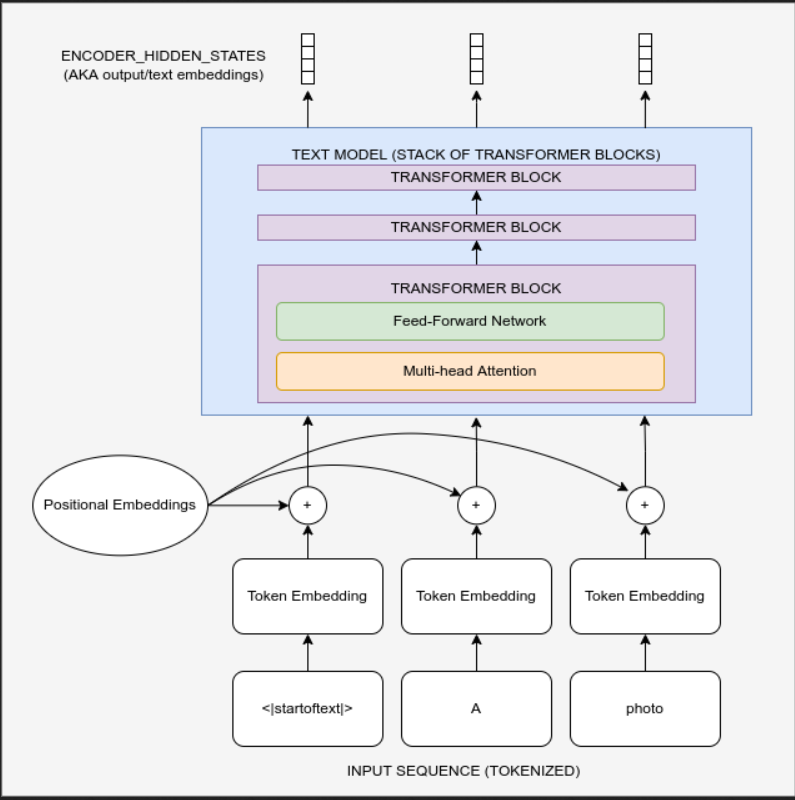

We want to mess with these input embeddings (specifically the token embeddings) before we send them through the rest of the model, but first we should check that we know how to do that. I read the code of the text_encoders forward method, and based on that the code for the forward method of the text_model that the text_encoder wraps. To inspect it yourself, type ??text_encoder.text_model.forward and you'll get the function info and source code - a useful debugging trick!

In [ ]:
batch_size,seq_length,embedding_size=input_embeddings.shape
print(f"Batch size :{batch_size} \n Sequence length :{seq_length} \n Embedding size :{embedding_size}")

In [ ]:
text_encoder.text_model.encoder.

In [252]:
def get_output_embeds(input_embeddings):
    # CLIP's text model uses causal mask, so we prepare it here:
    bsz, seq_len = input_embeddings.shape[:2]
    causal_attention_mask = text_encoder.text_model._build_causal_attention_mask(bsz, seq_len, dtype=input_embeddings.dtype)

    # Getting the output embeddings involves calling the model with passing output_hidden_states=True
    # so that it doesn't just return the pooled final predictions:
    encoder_outputs = text_encoder.text_model.encoder(
        inputs_embeds=input_embeddings,
        attention_mask=None, # We aren't using an attention mask so that can be None
        causal_attention_mask=causal_attention_mask.to(torch_device),
        output_attentions=None,
        output_hidden_states=True, # We want the output embs not the final output
        return_dict=None,
    )

    # We're interested in the output hidden state only
    output = encoder_outputs[0]

    # There is a final layer norm we need to pass these through
    output = text_encoder.text_model.final_layer_norm(output)

    # And now they're ready!
    return output


In [ ]:
out_embs_test = get_output_embeds(input_embeddings) # Feed through the model with our new function

In [ ]:
import torch
import torch.nn as nn

class TransformerEmbedding(nn.Module):
    def __init__(self, vocab_size, embed_dim, max_position_embeddings):
        super(TransformerEmbedding, self).__init__()
        self.token_embedding = nn.Embedding(vocab_size, embed_dim)
        self.position_embedding = nn.Embedding(max_position_embeddings, embed_dim)
        self.embed_dim = embed_dim

    def forward(self, input_ids):
        # Get the token embeddings
        token_embeddings = self.token_embedding(input_ids)
        
        # Create position ids
        position_ids = torch.arange(input_ids.size(1), dtype=torch.long, device=input_ids.device)
        position_ids = position_ids.unsqueeze(0).expand_as(input_ids)
        
        # Get the positional embeddings
        positional_embeddings = self.position_embedding(position_ids)
        
        # Combine token and positional embeddings
        embeddings = token_embeddings + positional_embeddings
        return embeddings

# Example usage
vocab_size = 30522
embed_dim = 512
max_position_embeddings = 512

model = TransformerEmbedding(vocab_size, embed_dim, max_position_embeddings)
input_ids = torch.tensor([[101, 2054, 2003, 1996, 2171, 102]])  # Example input token IDs
embeddings = model(input_ids)
print(embeddings.shape)  # Output: torch.Size([1, 6, 512])